In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# read the datasets
df = pd.read_excel("project4.xlsx")
df.head(3)

,Row ID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,Sub-Category,ProductName,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [3]:
# describing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Row ID        9994 non-null   int64         
 1   OrderID       9994 non-null   object        
 2   OrderDate     9994 non-null   datetime64[ns]
 3   ShipDate      9994 non-null   datetime64[ns]
 4   ShipMode      9994 non-null   object        
 5   CustomerID    9994 non-null   object        
 6   CustomerName  9994 non-null   object        
 7   Segment       9994 non-null   object        
 8   Country       9994 non-null   object        
 9   City          9994 non-null   object        
 10  State         9994 non-null   object        
 11  PostalCode    9994 non-null   int64         
 12  Region        9994 non-null   object        
 13  ProductID     9994 non-null   object        
 14  Category      9994 non-null   object        
 15  Sub-Category  9994 non-null   object  

In [4]:
# rows and columns
df.shape

(9994, 21)

In [5]:
# finding out null values if any
df.isnull().sum()

Row ID          0
OrderID         0
OrderDate       0
ShipDate        0
ShipMode        0
CustomerID      0
CustomerName    0
Segment         0
Country         0
City            0
State           0
PostalCode      0
Region          0
ProductID       0
Category        0
Sub-Category    0
ProductName     0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

In [6]:
df = df.sort_values(by='OrderDate')
df.head(3)

,Row ID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,Sub-Category,ProductName,Sales,Quantity,Discount,Profit
7980,7981,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
739,740,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
740,741,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748


In [7]:
# converting from date time to object
from datetime import datetime
def convert_datetime(dt):
    return datetime.strftime(dt, '%Y-%m-%d %H:%M-%S')

df['OrderDate']= df ['OrderDate'].apply(convert_datetime)
df['ShipDate']= df ['ShipDate'].apply(convert_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 7980 to 906
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   OrderID       9994 non-null   object 
 2   OrderDate     9994 non-null   object 
 3   ShipDate      9994 non-null   object 
 4   ShipMode      9994 non-null   object 
 5   CustomerID    9994 non-null   object 
 6   CustomerName  9994 non-null   object 
 7   Segment       9994 non-null   object 
 8   Country       9994 non-null   object 
 9   City          9994 non-null   object 
 10  State         9994 non-null   object 
 11  PostalCode    9994 non-null   int64  
 12  Region        9994 non-null   object 
 13  ProductID     9994 non-null   object 
 14  Category      9994 non-null   object 
 15  Sub-Category  9994 non-null   object 
 16  ProductName   9994 non-null   object 
 17  Sales         9994 non-null   float64
 18  Quantity      9994 non-nul

In [8]:
# set data as index
df = df.set_index('OrderDate')
df.head(3)

,Row ID,OrderID,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,State,PostalCode,Region,ProductID,Category,Sub-Category,ProductName,Sales,Quantity,Discount,Profit
OrderDate,,,,,,,,,,,,,,,,,,,,
2014-01-03 00:00-00,7981,CA-2014-103800,2014-01-07 00:00-00,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
2014-01-04 00:00-00,740,CA-2014-112326,2014-01-08 00:00-00,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2014-01-04 00:00-00,741,CA-2014-112326,2014-01-08 00:00-00,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748


In [9]:
# describing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 2014-01-03 00:00-00 to 2017-12-30 00:00-00
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   OrderID       9994 non-null   object 
 2   ShipDate      9994 non-null   object 
 3   ShipMode      9994 non-null   object 
 4   CustomerID    9994 non-null   object 
 5   CustomerName  9994 non-null   object 
 6   Segment       9994 non-null   object 
 7   Country       9994 non-null   object 
 8   City          9994 non-null   object 
 9   State         9994 non-null   object 
 10  PostalCode    9994 non-null   int64  
 11  Region        9994 non-null   object 
 12  ProductID     9994 non-null   object 
 13  Category      9994 non-null   object 
 14  Sub-Category  9994 non-null   object 
 15  ProductName   9994 non-null   object 
 16  Sales         9994 non-null   float64
 17  Quantity      9994 non-null   int64  
 18  

In [10]:
# adding frequency to index
df.index = pd.DatetimeIndex(df.index).to_period('D')

In [11]:
data = df['Sales']
data.head()

OrderDate
2014-01-03     16.448
2014-01-04     11.784
2014-01-04    272.736
2014-01-04      3.540
2014-01-05     19.536
Freq: D, Name: Sales, dtype: float64

In [12]:
data.tail()

OrderDate
2017-12-30      3.024
2017-12-30     52.776
2017-12-30     90.930
2017-12-30     13.904
2017-12-30    323.136
Freq: D, Name: Sales, dtype: float64

In [13]:
type(data)

pandas.core.series.Series

<AxesSubplot:xlabel='OrderDate'>

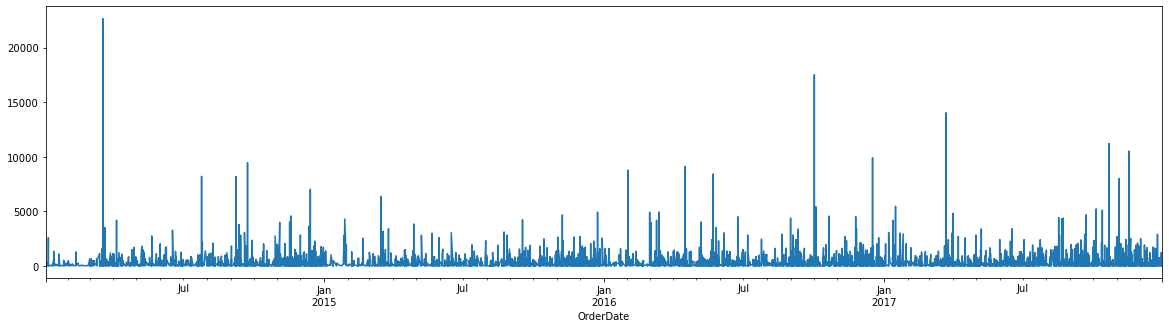

In [14]:
# the plot shows stationarity
data.plot(figsize=(20, 5))

In [15]:
# Split exogenous data
exo_df = df[['Quantity', 
             'Discount', 
             'Profit']]
exo_df.head()

,Quantity,Discount,Profit
OrderDate,,,
2014-01-03,2,0.2,5.5512
2014-01-04,3,0.2,4.2717
2014-01-04,3,0.2,-64.7748
2014-01-04,2,0.8,-5.4870
2014-01-05,3,0.2,4.8840


In [16]:
# sample the data with respect to 7 days
# D = daily
week_df = df.resample('7D').mean()
week_df.head(3)

,Row ID,PostalCode,Sales,Quantity,Discount,Profit
OrderDate,,,,,,
2014-01-03,5184.944444,55900.777778,269.935889,3.222222,0.188889,68.969633
2014-01-10,2780.700000,47170.750000,206.521950,3.750000,0.152500,35.306630
2014-01-17,5289.720000,65833.760000,127.543840,3.920000,0.120000,13.047980


In [17]:
week_data = week_df['Sales']
week_data.head()

OrderDate
2014-01-03    269.935889
2014-01-10    206.521950
2014-01-17    127.543840
2014-01-24    117.889867
2014-01-31    109.515714
Freq: 7D, Name: Sales, dtype: float64

<AxesSubplot:xlabel='OrderDate'>

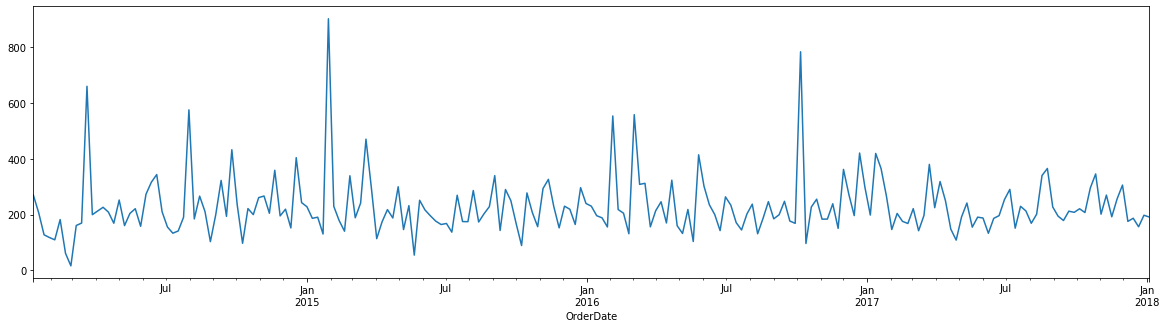

In [18]:
# the plot shows stationarity
week_data.plot(figsize=(20, 5))

In [19]:
week_df.shape

(209, 6)

In [20]:
# split the data into train and test
ss = int(0.7 * len(week_df))

train_df = week_df.iloc[:ss]
train_df.head()

,Row ID,PostalCode,Sales,Quantity,Discount,Profit
OrderDate,,,,,,
2014-01-03,5184.944444,55900.777778,269.935889,3.222222,0.188889,68.969633
2014-01-10,2780.700000,47170.750000,206.521950,3.750000,0.152500,35.306630
2014-01-17,5289.720000,65833.760000,127.543840,3.920000,0.120000,13.047980
2014-01-24,4108.266667,43608.866667,117.889867,3.400000,0.026667,11.532373
2014-01-31,3826.928571,64938.142857,109.515714,3.285714,0.189286,26.862571


In [21]:
train_data = train_df['Sales']
train_data.head()

OrderDate
2014-01-03    269.935889
2014-01-10    206.521950
2014-01-17    127.543840
2014-01-24    117.889867
2014-01-31    109.515714
Freq: 7D, Name: Sales, dtype: float64

In [22]:
train_data.tail()

OrderDate
2016-09-16    176.807945
2016-09-23    168.581619
2016-09-30    782.893000
2016-10-07     96.395310
2016-10-14    226.967317
Freq: 7D, Name: Sales, dtype: float64

<AxesSubplot:xlabel='OrderDate'>

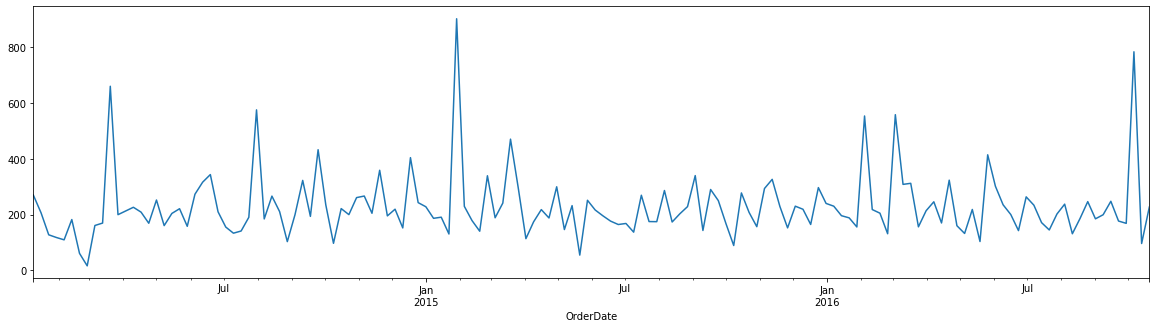

In [23]:
# the plot shows stationarity
train_data.plot(figsize=(20, 5))

In [24]:
test_df = week_df.iloc[ss:]
test_df.head()

,Row ID,PostalCode,Sales,Quantity,Discount,Profit
OrderDate,,,,,,
2016-10-21,5678.543478,56876.608696,255.120478,4.239130,0.100000,57.460511
2016-10-28,3836.196721,55234.786885,183.538459,3.967213,0.119672,26.842207
2016-11-04,5133.563107,65456.165049,183.852280,3.631068,0.148738,21.566374
2016-11-11,4827.506667,49342.026667,238.714080,3.600000,0.149333,29.169895
2016-11-18,3851.471154,55182.048077,150.546308,3.750000,0.181731,27.862687


In [25]:
test_data = test_df['Sales']
test_data.head()

OrderDate
2016-10-21    255.120478
2016-10-28    183.538459
2016-11-04    183.852280
2016-11-11    238.714080
2016-11-18    150.546308
Freq: 7D, Name: Sales, dtype: float64

In [26]:
test_data.tail()

OrderDate
2017-12-01    175.601259
2017-12-08    186.843115
2017-12-15    156.303625
2017-12-22    197.644894
2017-12-29    191.017053
Freq: 7D, Name: Sales, dtype: float64

<AxesSubplot:xlabel='OrderDate'>

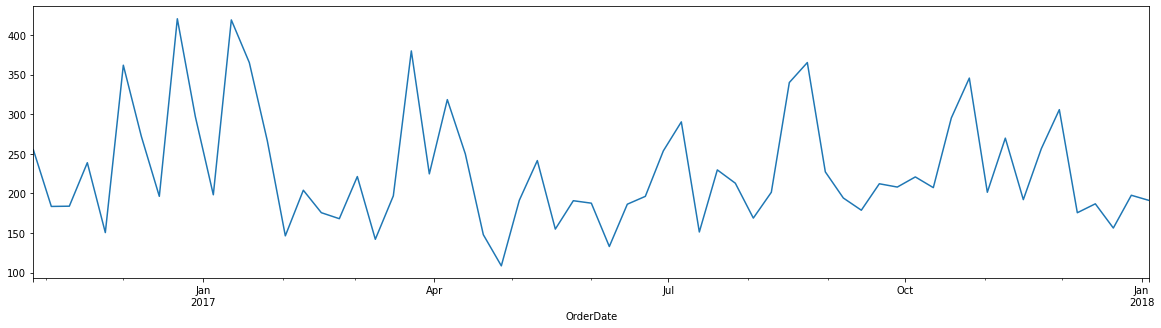

In [27]:
# the plot shows stationarity
test_data.plot(figsize=(20, 5))

In [28]:
print("train = {}, test = {}".format(len(train_df), len(test_df)))

train = 146, test = 63


In [29]:
# Split exogenous data
exo_train_df = train_df[['Quantity', 
                         'Discount', 
                         'Profit']]

# Split exogenous data
exo_test_df = test_df[['Quantity', 
                       'Discount', 
                       'Profit']]

------------------------------------TRAIN DATA----------------------------------------


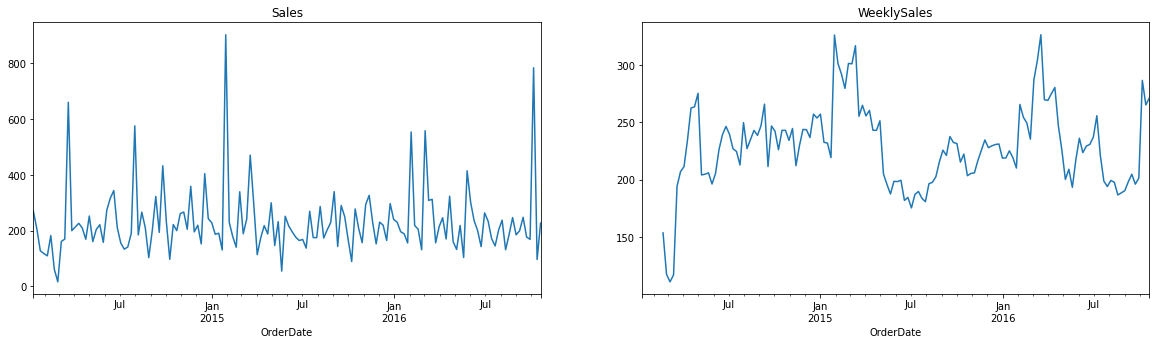

-------------------------------------TEST DATA------------------------------------------


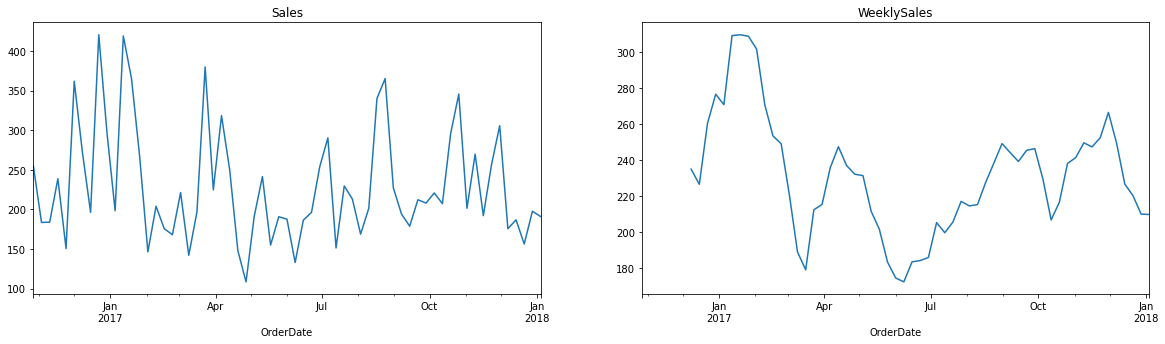

In [30]:
# TRAIN DATA
print("------------------------------------TRAIN DATA----------------------------------------")
fig,ax=plt.subplots(1,2,figsize=(20,5))
col='Sales'
ax[0].set_title(col)
ax[1].set_title("Weekly"+col)
train_data.plot(ax=ax[0])
train_data.rolling(window=7).mean().plot(ax=ax[1])
plt.show()

# TEST DATA
print("-------------------------------------TEST DATA------------------------------------------")
fig,ax=plt.subplots(1,2,figsize=(20,5))
col='Sales'
ax[0].set_title(col)
ax[1].set_title("Weekly"+col)
test_data.plot(ax=ax[0])
test_data.rolling(window=7).mean().plot(ax=ax[1])
plt.show()

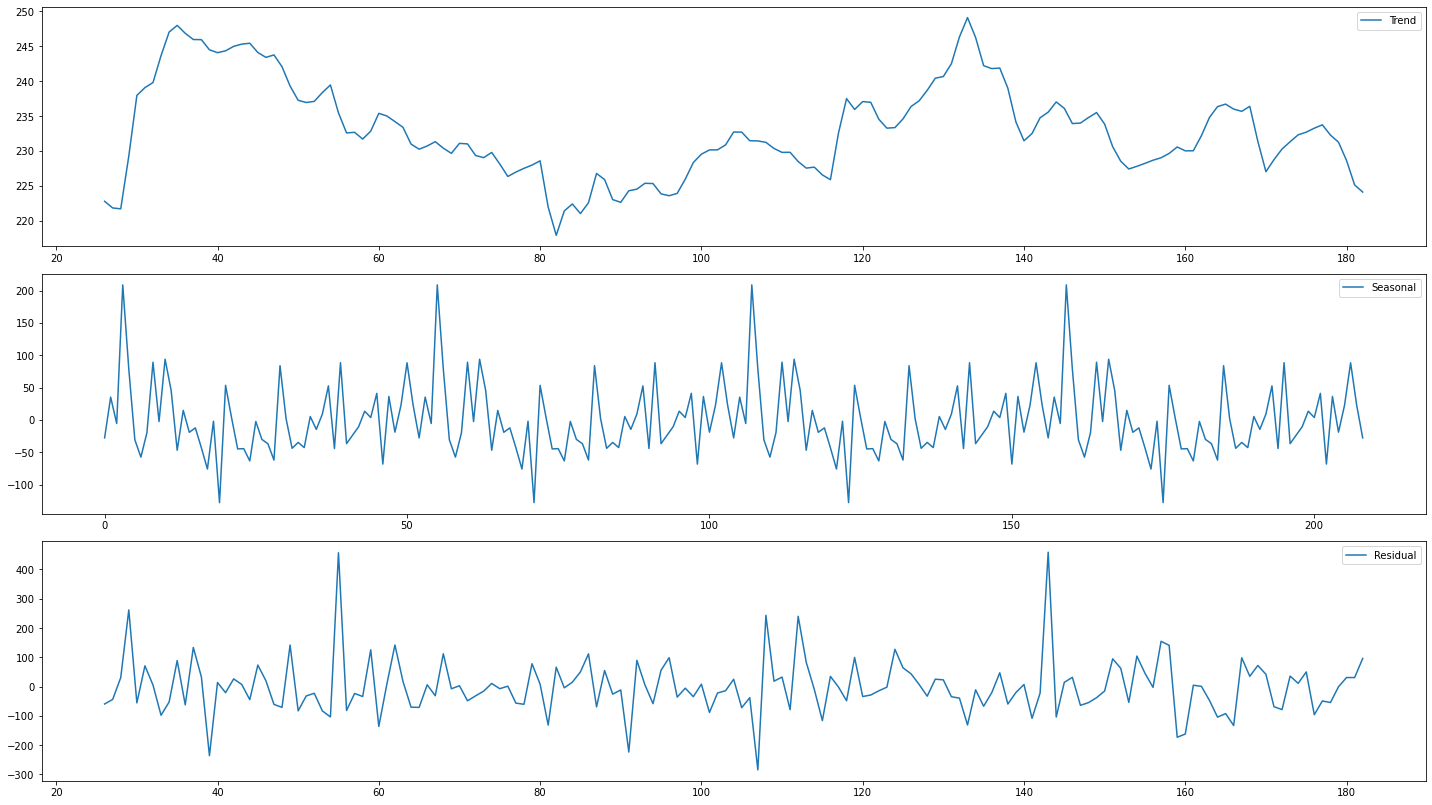

In [31]:
# different components of the Time series data

decomposition = seasonal_decompose(np.asarray(week_df.Sales), freq = 52) #freq is 52, as there are 52 WEEKS in a year.
d_trend = decomposition.trend
d_seasonal = decomposition.seasonal
d_residual = decomposition.resid

# plotting all the 3 graphs
fig,ax = plt.subplots(3,1,figsize = (20, 15))

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(d_seasonal,label = 'Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(d_residual,label = 'Residual')
plt.legend(loc = 'best')

plt.tight_layout()

In [32]:
# dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary. Make the data stationary before model building.'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary. Proceed to model building'.format(pvalue)
    return(msg)

# check the data for stationarity
checkStationarity(data)

'p-value=0.0. Data is stationary. Proceed to model building'

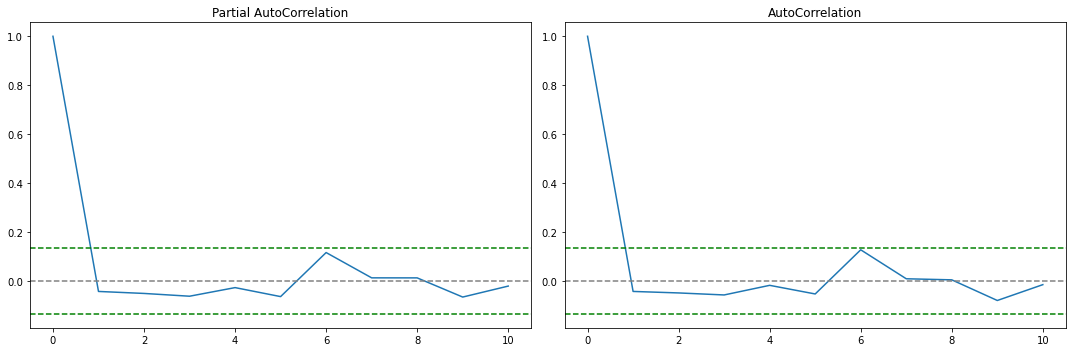

In [33]:
# since, lags cannot be determined at the beginning, set a random number initially
lag_acf = acf(week_data.values, nlags = 10)
lag_pacf = pacf(week_data.values, nlags = 10, method='ols')

fig,ax = plt.subplots(1,1,figsize=(15, 5))

# plot PACF (p)
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(week_data.values)),linestyle='--',color="green")
plt.axhline(y=1.96/np.sqrt(len(week_data.values)),linestyle='--',color="green")
plt.title("Partial AutoCorrelation")

# plot ACF (q)
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(week_data.values)),linestyle='--',color="green")
plt.axhline(y=1.96/np.sqrt(len(week_data.values)),linestyle='--',color="green")
plt.title("AutoCorrelation")

plt.tight_layout()

### ARMA

In [34]:
# Building ARMA mode

p_values = [0,1,2]
q_values = [0,1,2]
d=0
for p in p_values:
    for q in q_values:
        model = ARIMA(train_data, order=(p,d,q)).fit()
        print('------------------------------------------p and q values: ', p, q, '------------------------------------')
        print(model.summary())

------------------------------------------p and q values:  0 0 ------------------------------------
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  146
Model:                          ARIMA   Log Likelihood                -904.928
Date:                Mon, 23 May 2022   AIC                           1813.856
Time:                        17:26:02   BIC                           1819.823
Sample:                    01-03-2014   HQIC                          1816.280
                         - 10-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        228.8047     15.356     14.900      0.000     198.707     258.902
sigma2      1.416e+04   1047.20

------------------------------------------p and q values:  1 2 ------------------------------------
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  146
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -903.587
Date:                Mon, 23 May 2022   AIC                           1817.174
Time:                        17:26:03   BIC                           1832.092
Sample:                    01-03-2014   HQIC                          1823.236
                         - 10-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        228.7603     11.982     19.092      0.000     205.277     252.244
ar.L1          0.3956      1.15

In [35]:
# choosing arma model
# L-junk box value and AIC value is least when p = 2, q = 1
p = 1; d = 0; q = 2
arma_model = ARIMA(data, order = (p, d, q)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                 9994
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -78489.528
Date:                Mon, 23 May 2022   AIC                         156989.055
Time:                        17:26:06   BIC                         157025.104
Sample:                    01-03-2014   HQIC                        157001.258
                         - 12-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.8580      9.402     24.449      0.000     211.431     248.285
ar.L1          0.5896      1.499      0.393      0.694      -2.348       3.527
ma.L1         -0.5727      1.499     -0.382      0.702      -3.510       2.365
ma.L2         -0.0146      0.023     -0.624      0.532      -0.060       0.031
sigma2       3.88e+05    672.238    577.122      0.000    3.87e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          39105489.67
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            12.97
Prob(H) (two-sided):                  0.00   Kurtosis:                       308.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# predictions
predictions_1 = arma_model.predict(0, len(test_data)-4)
predictions_1.head()

OrderDate
2014-01-03    229.858001
2014-01-04    226.261740
2014-01-04    227.211579
2014-01-04    232.190356
2014-01-05    226.702217
Freq: D, Name: predicted_mean, dtype: float64

In [37]:
# actual vs predicted values

actual_1 = []; pred_1 = []

for i in range(len(predictions_1)):
    actual_1.append(test_df['Sales'][i])
    pred_1.append(predictions_1[i])

df_res_1 = pd.DataFrame({'actual':actual_1, 'predicted':pred_1})
df_res_1['error'] = df_res_1.actual - df_res_1.predicted
df_res_1.head()

,actual,predicted,error
0,255.120478,229.858001,25.262477
1,183.538459,226.261740,-42.723281
2,183.852280,227.211579,-43.359299
3,238.714080,232.190356,6.523724
4,150.546308,226.702217,-76.155909


In [38]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(arma_model.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Accept H0. Good model")

Accept H0. Good model


In [39]:
# Calculate error terms
msg_1 = 'ARMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse_1 = mean_squared_error(df_res_1.actual, df_res_1.predicted)
print(msg_1 + "\n\tMSE = {}\n\tRMSE = {}".format(mse_1,np.sqrt(mse_1)))

ARMA Model. Order=(1,0,2)
	MSE = 5328.389141978976
	RMSE = 72.99581592104424


Text(0.5, 1.0, 'ARMA Model. Order=(1,0,2)')

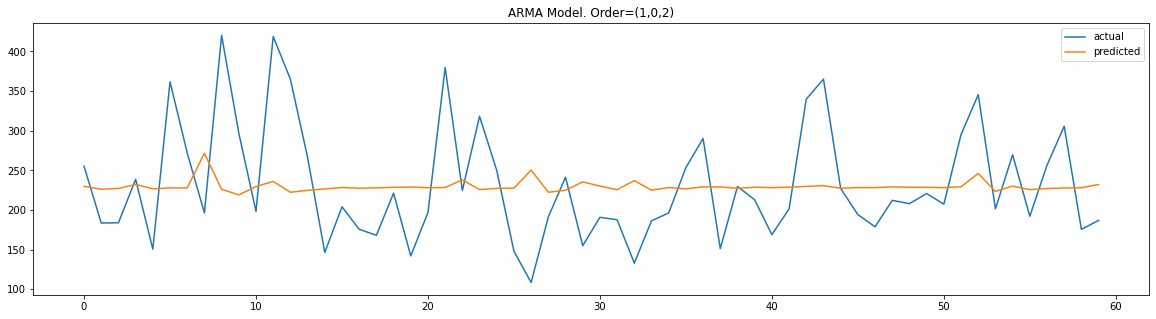

In [40]:
# plotting actual vs predicted values

df_res_1.actual.plot(figsize=(20, 5),legend=True)
df_res_1.predicted.plot(legend=True)

plt.title(msg_1)

<AxesSubplot:>

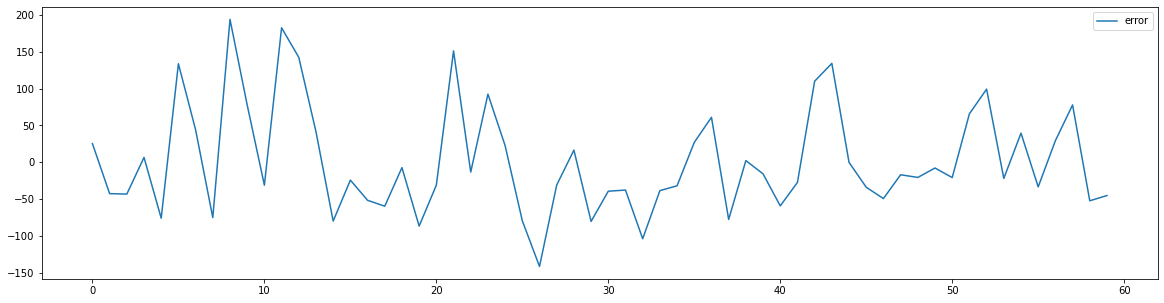

In [41]:
df_res_1.error.plot(figsize=(20, 5),legend=True) #errors

### ARIMA

In [42]:
# Use auto ARIMA for selection of p, d, q
# auto ARIMA (to help in the selection of p,d,q)
# p -> PACF (partial autocorrelation graph)
# q -> ACF (auto correlation graph)
# d -> differential level (from top)
model = auto_arima(df['Sales'], start_p = 0, max_p = 2, start_q = 0, max_q = 2, seasonal = False, trace = True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=158258.982, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=158077.420, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=158109.406, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=157965.609, Time=0.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=13.63 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=3.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=156987.260, Time=1.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=156985.352, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=156986.321, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=156987.363, Time=3.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=156985.618, Time=1.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=156989.248, Time=4.40 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 29.475 seconds
                               SARIMAX Results                              

In [43]:
# since best model is 0,0,0,; thus choiosing next best option
p = 1; d = 0; q = 2

In [44]:
arima_model = ARIMA(df['Sales'],order=(p,d,q)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                 9994
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -78489.528
Date:                Mon, 23 May 2022   AIC                         156989.055
Time:                        17:26:39   BIC                         157025.104
Sample:                    01-03-2014   HQIC                        157001.258
                         - 12-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.8580      9.402     24.449      0.000     211.431     248.285
ar.L1          0.5896      1.499      0.393      0.694      -2.348       3.527
ma.L1         -0.5727      1.499     -0.382      0.702      -3.510       2.365
ma.L2         -0.0146      0.023     -0.624      0.532      -0.060       0.031
sigma2       3.88e+05    672.238    577.122      0.000    3.87e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          39105489.67
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            12.97
Prob(H) (two-sided):                  0.00   Kurtosis:                       308.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Predict the test data using the model
# predictions
start = len(train_df) 
end = len(train_df) + len(test_df)-1

print('start = {}, end = {}'.format(start,end))

predictions_2 = arima_model.predict(start,end,typ='levels')
predictions_2

start = 146, end = 208


OrderDate
2014-03-03    227.579813
2014-03-03    228.301851
2014-03-03    233.224694
2014-03-03    229.808631
2014-03-03    237.358425
                 ...    
2014-03-17    226.303321
2014-03-17    253.218494
2014-03-17    219.914820
2014-03-17    224.281649
2014-03-17    225.590027
Freq: D, Name: predicted_mean, Length: 71, dtype: float64

In [46]:
# Collate actual, predicted, and error values together
# actual vs predicted values
# print("test = {}, predicted = {}".format(len(test), len(predictions) ))
actual_2 = []; pred_2 = []

for i in range(len(predictions_2)):
    actual_2.append(train_df['Sales'][i])
    pred_2.append(predictions_2[i])

df_res_2 = pd.DataFrame({'actual':actual_2, 'predicted':pred_2})
df_res_2['error'] = df_res_2.actual - df_res_2.predicted
df_res_2.head()

,actual,predicted,error
0,269.935889,227.579813,42.356075
1,206.521950,228.301851,-21.779901
2,127.543840,233.224694,-105.680854
3,117.889867,229.808631,-111.918764
4,109.515714,237.358425,-127.842711


In [47]:
df_res_2 = df_res_2.dropna()

In [48]:
# Box-Jenkins test to check model's goodness
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(arima_model.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Accept H0. Good model")

Accept H0. Good model


In [49]:
# Calculate error terms
msg_2 = 'ARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse_2 = mean_squared_error(df_res_2.actual, df_res_2.predicted)
print(msg_2 + "\n\tMSE = {}\n\tRMSE = {}".format(mse_2,np.sqrt(mse_2)))

ARIMA Model. Order=(1,0,2)
	MSE = 17368.530977487153
	RMSE = 131.7897225791418


Text(0.5, 1.0, 'ARIMA Model. Order=(1,0,2)')

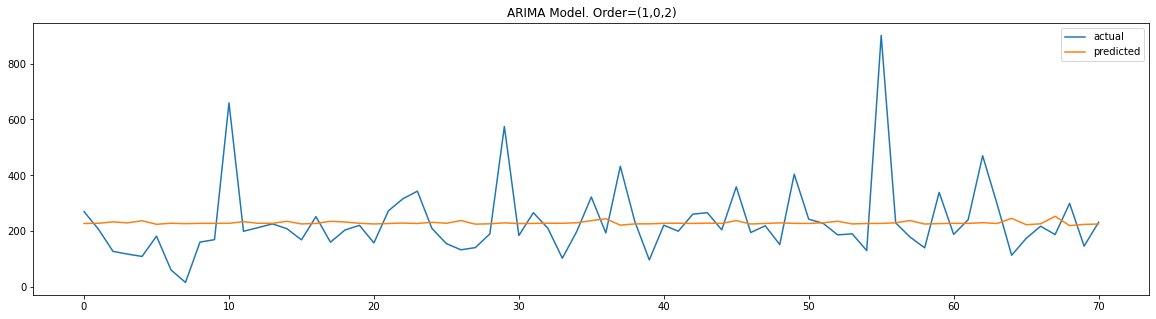

In [50]:
# plotting actual vs predicted values

df_res_2.actual.plot(figsize=(20, 5),legend=True)
df_res_2.predicted.plot(legend=True)

plt.title(msg_2)

<AxesSubplot:>

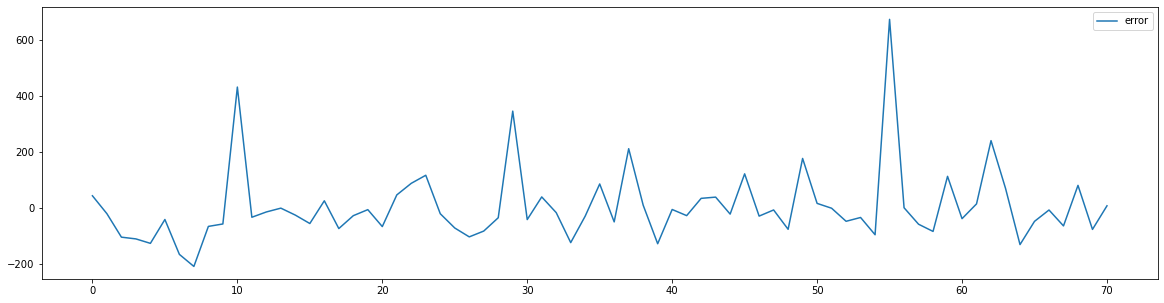

In [51]:
df_res_2.error.plot(figsize=(20, 5),legend=True) # errors

In [52]:
# Forecast the future data using the model
arima_model_2 = ARIMA(test_df['Sales'],order=(p,d,q)).fit()
forecast = arima_model_2.predict(start=len(test_df), end=len(test_df)+52, typ='levels')
forecast.head()

2018-01-05    212.495690
2018-01-12    236.075534
2018-01-19    224.790711
2018-01-26    230.549297
2018-02-02    227.610721
Freq: 7D, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'ARIMA Model. Order=(1,0,2)')

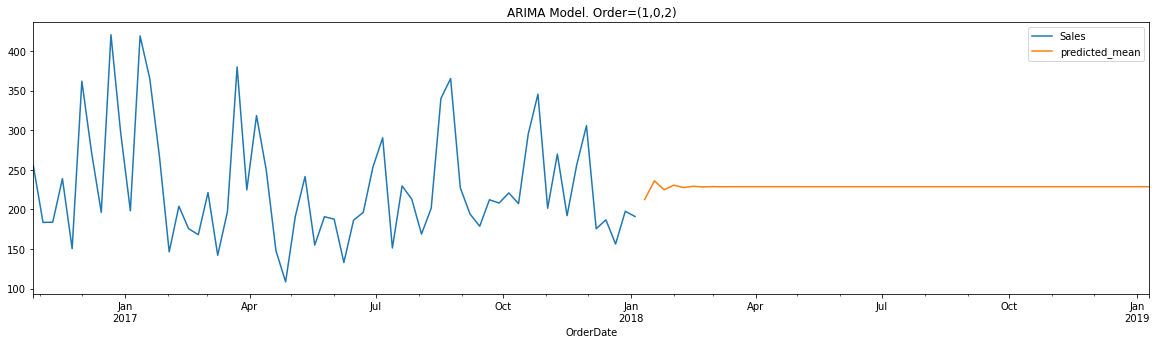

In [53]:
# Visualize the forecast
test_df['Sales'].plot(figsize=(20, 5),legend=True)
forecast.plot(legend=True)
plt.title(msg_2)

### SARIMA

In [54]:
# Build the SARIMA model

p_values = [0,1,2]
q_values = [0,1,2]
d=0
for p in p_values:
    for q in q_values:
        model = sm.tsa.statespace.SARIMAX(df['Sales'],order=(p,d,q),seasonal_order=(0,0,0,52)).fit()
        print('------------------------------------------p and q values: ', p, q, '------------------------------------')
        print(model.summary())

------------------------------------------p and q values:  0 0 ------------------------------------
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 9994
Model:                        SARIMAX   Log Likelihood              -79128.491
Date:                Mon, 23 May 2022   AIC                         158258.982
Time:                        17:26:42   BIC                         158266.191
Sample:                    01-03-2014   HQIC                        158261.422
                         - 12-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.412e+05    554.690    795.454      0.000     4.4e+05    4.42e+05
Ljung-Box (L1) (Q):            

------------------------------------------p and q values:  1 2 ------------------------------------
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 9994
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -78494.619
Date:                Mon, 23 May 2022   AIC                         156997.239
Time:                        17:27:02   BIC                         157026.078
Sample:                    01-03-2014   HQIC                        157007.001
                         - 12-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    4.2e-06   2.38e+05      0.000       1.000       1.000
ma.L1         -0.9826      0.01

In [55]:
# L-junk box value and AIC value is least when p = 2, q = 1
p = 1; d = 0; q = 2

In [56]:
# choosing a sarima model
sarima_model = sm.tsa.statespace.SARIMAX(df['Sales'],order=(p,d,q),seasonal_order=(1,0,0,52)).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                 9994
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood              -78494.790
Date:                             Mon, 23 May 2022   AIC                         156999.579
Time:                                     17:30:37   BIC                         157035.628
Sample:                                 01-03-2014   HQIC                        157011.782
                                      - 12-30-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   5.04e-06   1.99e+05      0.000       1.000       1.000
ma.L1         -0.9823      0.010   -102.066      0.000      -1.001      -0.963
ma.L2         -0.0172      0.010     -1.808      0.071      -0.036       0.001
ar.S.L52      -0.0008      0.013     -0.064      0.949      -0.026       0.025
sigma2      3.875e+05   4.78e-09   8.11e+13      0.000    3.88e+05    3.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          39272565.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            12.98
Prob(H) (two-sided):                  0.00   Kurtosis:                       309.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+28. Standard errors may be unstable.
"""

In [57]:
# predictions
start = len(train_df) 
end = len(train_df) + len(test_df) - 4

print('start = {}, end = {}'.format(start,end))

predictions_3 = sarima_model.predict(start,end,typ='levels')
predictions_3


#predictions_3 = sarima_model.predict(0, len(test_df)-1)
#predictions_3

start = 146, end = 205


OrderDate
2014-03-03    132.877180
2014-03-03    132.370666
2014-03-03    138.304020
2014-03-03    136.417309
2014-03-03    147.262614
                 ...    
2014-03-17    142.138038
2014-03-17    174.952544
2014-03-17    146.481578
2014-03-17    146.777917
2014-03-17    145.855344
Freq: D, Name: predicted_mean, Length: 71, dtype: float64

In [58]:
# Collate actual, predicted, and errors together
actual_3 = []; pred_3 = []

for i in range(len(predictions_3)):
    actual_3.append(train_df['Sales'][i])
    pred_3.append(predictions_3[i])

df_res_3 = pd.DataFrame({'actual':actual_3, 'predicted':pred_3})
df_res_3['error'] = df_res_3.actual - df_res_3.predicted
df_res_3

,actual,predicted,error
0,269.935889,132.877180,137.058709
1,206.521950,132.370666,74.151284
2,127.543840,138.304020,-10.760180
3,117.889867,136.417309,-18.527442
4,109.515714,147.262614,-37.746900
...,...,...,...
66,217.767951,142.138038,75.629914
67,187.763026,174.952544,12.810482
68,299.490961,146.481578,153.009383
69,146.341931,146.777917,-0.435986


In [59]:
df_res_3 = df_res_3.dropna()

In [60]:
# Box-Jenkins test to check model's goodness
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(sarima_model.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Accept H0. Good model")

Accept H0. Good model


In [61]:
# Calculate error terms
msg_3 = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
mse_3 = mean_squared_error(df_res_3.actual, df_res_3.predicted)
print(msg_3 + "\n\tMSE = {}\n\tRMSE = {}".format(mse_3,np.sqrt(mse_3)))

SARIMA Model. Order=(1,0,2)
	MSE = 25694.814842072705
	RMSE = 160.29602253977703


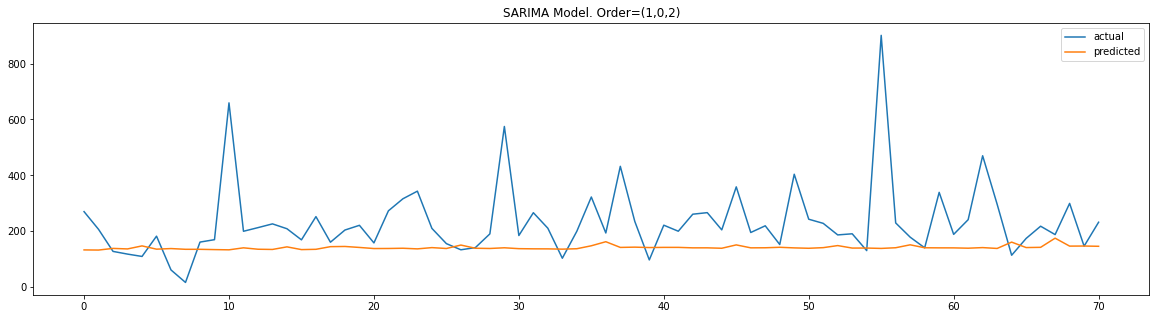

In [62]:
df_res_3.actual.plot(figsize=(20, 5),legend=True)
df_res_3.predicted.plot(legend=True)

plt.title(msg_3);

<AxesSubplot:>

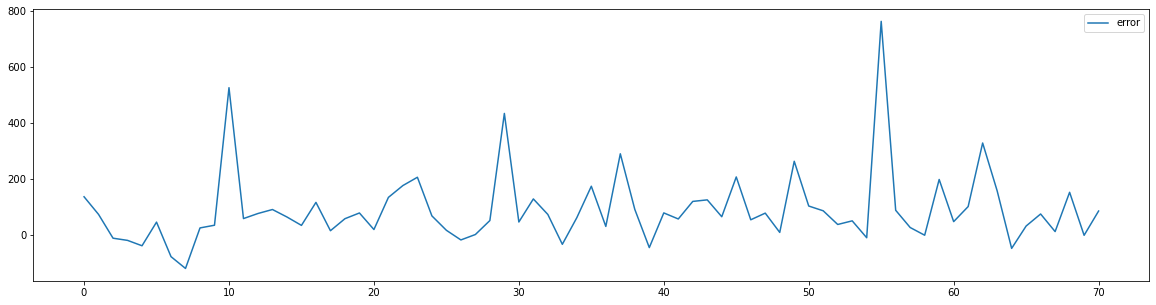

In [63]:
df_res_3.error.plot(figsize=(20, 5),legend=True) #errors

In [64]:
# Forecast the future data using the model
sarima_model_2 = sm.tsa.statespace.SARIMAX(test_df['Sales'],order=(p,d,q),seasonal_order=(1,0,0,52)).fit()
forecast = sarima_model_2.predict(start=len(test_df), end=len(test_df)+52, typ='levels').rename('Forecast')
forecast.head()

C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2018-01-05    215.474458
2018-01-12    226.445147
2018-01-19    227.652301
2018-01-26    229.118542
2018-02-02    228.414130
Freq: 7D, Name: Forecast, dtype: float64

Text(0.5, 1.0, 'SARIMA Model. Order=(1,0,2)')

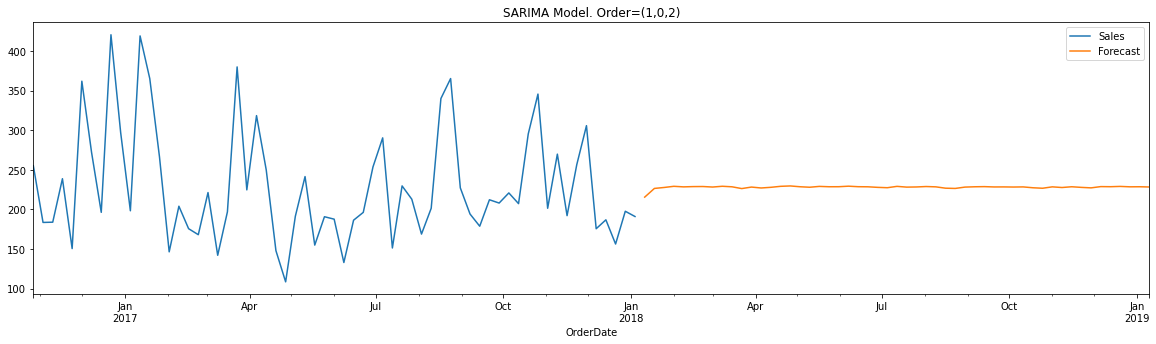

In [65]:
# Visualize the forecast
test_df['Sales'].plot(figsize=(20, 5),legend=True)
forecast.plot(legend=True)
plt.title(msg_3)

### ARMA

In [66]:
print(msg_1 + "\n\tMSE = {}\n\tRMSE = {}".format(mse_1,np.sqrt(mse_1)))

ARMA Model. Order=(1,0,2)
	MSE = 5328.389141978976
	RMSE = 72.99581592104424


### ARIMA

In [67]:
print(msg_2 + "\n\tMSE = {}\n\tRMSE = {}".format(mse_2,np.sqrt(mse_2)))

ARIMA Model. Order=(1,0,2)
	MSE = 17368.530977487153
	RMSE = 131.7897225791418


### SARIMA

In [68]:
print(msg_3 + "\n\tMSE = {}\n\tRMSE = {}".format(mse_3,np.sqrt(mse_3)))

SARIMA Model. Order=(1,0,2)
	MSE = 25694.814842072705
	RMSE = 160.29602253977703
